$$
\newcommand{\mat}[1]{\boldsymbol {#1}}
\newcommand{\mattr}[1]{\boldsymbol {#1}^\top}
\newcommand{\matinv}[1]{\boldsymbol {#1}^{-1}}
\newcommand{\vec}[1]{\boldsymbol {#1}}
\newcommand{\vectr}[1]{\boldsymbol {#1}^\top}
\newcommand{\rvar}[1]{\mathrm {#1}}
\newcommand{\rvec}[1]{\boldsymbol{\mathrm{#1}}}
\newcommand{\diag}{\mathop{\mathrm {diag}}}
\newcommand{\set}[1]{\mathbb {#1}}
\newcommand{\norm}[1]{\left\lVert#1\right\rVert}
\newcommand{\pderiv}[2]{\frac{\partial #1}{\partial #2}}
\newcommand{\bm}[1]{{\bf #1}}
\newcommand{\bb}[1]{\bm{\mathrm{#1}}}
$$

# Part 3: Generative Adversarial Networks
<a id=part3></a>

In this part we will implement and train a generative adversarial network and apply it to the task of image generation.

In [1]:
import unittest
import os
import sys
import pathlib
import urllib
import shutil
import re
import zipfile

import numpy as np
import torch
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2

test = unittest.TestCase()
plt.rcParams.update({'font.size': 12})
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cuda


### Obtaining the dataset
<a id=part3_1></a>

We'll use the same data as in Part 2.

But again, to use a custom dataset, edit the `PART3_CUSTOM_DATA_URL` variable in `hw3/answers.py`.

In [2]:
import cs236605.plot as plot
import cs236605.download
from hw3.answers import PART3_CUSTOM_DATA_URL as CUSTOM_DATA_URL

DATA_DIR = pathlib.Path.home().joinpath('.pytorch-datasets')
if CUSTOM_DATA_URL is None:
    DATA_URL = 'http://vis-www.cs.umass.edu/lfw/lfw-bush.zip'
else:
    DATA_URL = CUSTOM_DATA_URL

_, dataset_dir = cs236605.download.download_data(out_path=DATA_DIR, url=DATA_URL, extract=True, force=False)

File /home/sdrork12/.pytorch-datasets/lfw-bush.zip exists, skipping download.
Extracting /home/sdrork12/.pytorch-datasets/lfw-bush.zip...
Extracted 531 to /home/sdrork12/.pytorch-datasets/lfw/George_W_Bush


Create a `Dataset` object that will load the extraced images:

In [3]:
import torchvision.transforms as T
from torchvision.datasets import ImageFolder

im_size = 64
tf = T.Compose([
    # Resize to constant spatial dimensions
    T.Resize((im_size, im_size)),
    # PIL.Image -> torch.Tensor
    T.ToTensor(),
    # Dynamic range [0,1] -> [-1, 1]
    T.Normalize(mean=(.5,.5,.5), std=(.5,.5,.5)),
])

ds_gwb = ImageFolder(os.path.dirname(dataset_dir), tf)

OK, let's see what we got. You can run the following block multiple times to display a random subset of images from the dataset.

Found 530 images in dataset folder.


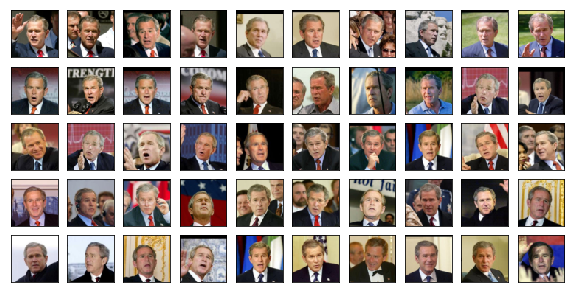

In [4]:
_ = plot.dataset_first_n(ds_gwb, 50, figsize=(10,5), nrows=5)
print(f'Found {len(ds_gwb)} images in dataset folder.')

In [5]:
x0, y0 = ds_gwb[0]
x0 = x0.unsqueeze(0).to(device)
print(x0.shape)

test.assertSequenceEqual(x0.shape, (1, 3, im_size, im_size))

torch.Size([1, 3, 64, 64])


## Generative Adversarial Nets (GANs)
<a id=part3_2></a>

GANs, first proposed in a [paper](https://arxiv.org/pdf/1406.2661.pdf) by Ian Goodfellow in 2014 are today arguably the most popular type of generative model. GANs are currently producing state of the art
results in generative tasks over many different domains.

In a GAN model, two different neural networks compete against each other: A **generator** and a **discriminator**.

- The Generator, which we'll denote as $\Psi _{\bb{\gamma}} : \mathcal{U} \rightarrow \mathcal{X}$, maps a latent-space variable
$\bb{u}\sim\mathcal{N}(\bb{0},\bb{I})$ to an instance-space variable $\bb{x}$ (e.g. an image).
Thus a parametric evidence distribution $p_{\bb{\gamma}}(\bb{X})$ is generated,
which we typically would like to be as close as possible to the real evidence distribution, $p(\bb{X})$.

- The Discriminator, $\Delta _{\bb{\delta}} : \mathcal{X} \rightarrow [0,1]$, is a network which,
given an instance-space variable $\bb{x}$, returns the  probability that $\bb{x}$ is real, i.e. that $\bb{x}$
was sampled from $p(\bb{X})$ and not $p_{\bb{\gamma}}(\bb{X})$.


<img src="imgs/gan.jpg" />

### Training GANs
<a id=part3_3></a>

The generator is trained to generate "fake" instances which will maximally fool the
discriminator into returning that they're real. Mathematically, the generator's parameters
$\bb{\gamma}$ should be chosen such as to **maximize** the expression
$$
\mathbb{E} _{\bb{z} \sim p(\bb{Z}) } \log (\Delta _{\bb{\delta}}(\Psi _{\bb{\gamma}} (\bb{z}) )).
$$

The discriminator is trained to classify between real images, coming from the training set,
and fake images generated by the generator.
Mathematically, the discriminator's parameters $\bb{\delta}$ should be chosen such as to
**maximize** the expression
$$
\mathbb{E} _{\bb{x} \sim p(\bb{X}) } \log \Delta _{\bb{\delta}}(\bb{x})  \, + \,
\mathbb{E} _{\bb{z} \sim p(\bb{Z}) } \log (1-\Delta _{\bb{\delta}}(\Psi _{\bb{\gamma}} (\bb{z}) )).
$$

These two competing objectives can thus be expressed as the following min-max optimization:
$$
\min _{\bb{\gamma}} \max _{\bb{\delta}} \,
\mathbb{E} _{\bb{x} \sim p(\bb{X}) } \log \Delta _{\bb{\delta}}(\bb{x})  \, + \,
\mathbb{E} _{\bb{z} \sim p(\bb{Z}) } \log (1-\Delta _{\bb{\delta}}(\Psi _{\bb{\gamma}} (\bb{z}) )).
$$

A key insight into GANs is that we can interpret the above maximum as the loss with respect to
$\bb{\gamma}$:

$$
L({\bb{\gamma}}) =
\max _{\bb{\delta}} \, \mathbb{E} _{\bb{x} \sim p(\bb{X}) } \log \Delta _{\bb{\delta}}(\bb{x})  \, + \,
  \mathbb{E} _{\bb{z} \sim p(\bb{Z}) } \log (1-\Delta _{\bb{\delta}}(\Psi _{\bb{\gamma}} (\bb{z}) )).
$$

This means that the generator's loss function trains together with the generator
itself in an adversarial manner. In contrast, when training our VAE we used a fixed L2 norm
as a data loss term.

### Model Implementation
<a id=part3_4></a>

We'll now implement a Deep Convolutional GAN (DCGAN) model.
See the DCGAN [paper](https://arxiv.org/pdf/1511.06434.pdf) for architecture ideas and tips for training.

**TODO**: Implement the `Discriminator` class in the `hw3/gan.py` module.
If you wish you can reuse the `EncoderCNN` class from the VAE model as the first part of the Discriminator.

In [6]:
import hw3.gan as gan

dsc = gan.Discriminator(in_size=x0[0].shape).to(device)
print(dsc)

d0 = dsc(x0)
print(d0.shape)

test.assertSequenceEqual(d0.shape, (1,1))

Discriminator(
  (feature_extractor): Sequential(
    (0): Conv2d(3, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): LeakyReLU(negative_slope=0.01)
    (4): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): LeakyReLU(negative_slope=0.01)
    (8): Conv2d(128, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): LeakyReLU(negative_slope=0.01)
  )
  (classifier): Sequential(
    (0): Linear(in_features=16384, out_features=

**TODO**: Implement the `Generator` class in the `hw3/gan.py` module.
If you wish you can reuse the `DecoderCNN` class from the VAE model as the last part of the Generator.

In [7]:
z_dim = 128
gen = gan.Generator(z_dim, 4).to(device)
print(gen)

z = torch.randn(1, z_dim).to(device)
xr = gen(z)
print(xr.shape)

test.assertSequenceEqual(x0.shape, xr.shape)

Generator(
  (seq): Sequential(
    (0): ConvTranspose2d(128, 512, kernel_size=(4, 4), stride=(2, 2), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU()
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU()
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)
torch.Size([1, 3, 64, 64])


### Loss Implementation
<a id=part3_5></a>

Let's begin with the discriminator's loss function.
Based on the above we can flip the sign and say we want to update the 
Discriminator's parameters $\bb{\delta}$ so that they **minimize** the expression
$$
- \mathbb{E} _{\bb{x} \sim p(\bb{X}) } \log \Delta _{\bb{\delta}}(\bb{x})  \, - \,
\mathbb{E} _{\bb{z} \sim p(\bb{Z}) } \log (1-\Delta _{\bb{\delta}}(\Psi _{\bb{\gamma}} (\bb{z}) )).
$$

We're using the Discriminator twice in this expression;
once to classify data from the real data distribution and
once again to classify generated data.
Therefore our loss should be computed based on these two terms.
Notice that since the discriminator returns a probability, we can formulate the above as two cross-entropy losses.

GANs are notoriously diffucult to train.
One common trick for improving GAN stability during training is to make the classification labels noisy for the discriminator. This can be seen as a form of regularization, to help prevent the discriminator from overfitting.

We'll incorporate this idea into our loss function. Instead of labels being equal to 0 or 1, we'll make them
"fuzzy", i.e. random numbers in the ranges $[0\pm\epsilon]$ and $[1\pm\epsilon]$.

**TODO**: Implement the `discriminator_loss_fn()` function in the `hw3/gan.py` module.

In [8]:
from hw3.gan import discriminator_loss_fn
torch.manual_seed(42)

y_data = torch.rand(10) * 10
y_generated = torch.rand(10) * 10

loss = discriminator_loss_fn(y_data, y_generated, data_label=1, label_noise=0.3)
print(loss)

test.assertAlmostEqual(loss.item(), 6.4808731, delta=1e-5)

tensor(6.4809)


Similarly, the generator's parameters $\bb{\gamma}$ should **minimize** the expression
$$
-\mathbb{E} _{\bb{z} \sim p(\bb{Z}) } \log (\Delta _{\bb{\delta}}(\Psi _{\bb{\gamma}} (\bb{z}) ))
$$

which can also be seen as a cross-entropy term.

**TODO**: Implement the `generator_loss_fn()` function in the `hw3/gan.py` module.

In [9]:
from hw3.gan import generator_loss_fn
torch.manual_seed(42)

y_generated = torch.rand(20) * 10

loss = generator_loss_fn(y_generated, data_label=1)
print(loss)

test.assertAlmostEqual(loss.item(), 0.0222969, delta=1e-5)

tensor(0.0223)


### Sampling
<a id=part3_6></a>

Sampling from a GAN is straightforward, since it learns to generate data from an isotropic Gaussian latent space distribution.

There is an important nuance however. Sampling is required during the process of training the GAN, since
we generate fake images to show the discriminator.
As you'll seen in the next section,  in some cases we'll need our samples to have gradients.

**TODO**: Implement the `sample()` method in the `Generator` class within the `hw3/gan.py` module.

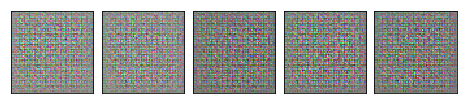

In [10]:
samples = gen.sample(5, with_grad=False)
test.assertSequenceEqual(samples.shape, (5, *x0.shape[1:]))
test.assertIsNone(samples.grad_fn)
_ = plot.tensors_as_images(samples.cpu())

samples = gen.sample(5, with_grad=True)
test.assertSequenceEqual(samples.shape, (5, *x0.shape[1:]))
test.assertIsNotNone(samples.grad_fn)

### Training
<a id=part3_7></a>

Training GANs is a bit different since we need to train two models simultaneously, each with it's own separate loss function and optimizer. We'll implement the training logic as a function that handles one batch of data
and updates both the discriminator and the generator based on it.

As mentioned above, GANs are considered hard to train. To get some ideas and tips you can see this [paper](https://arxiv.org/pdf/1606.03498.pdf), this list of ["GAN hacks"](https://github.com/soumith/ganhacks) or just do it the hard way :)

**TODO**:
1. Implement the `train_batch` function in the `hw3/gan.py` module.
2. Tweak the hyperparameters in the `part3_gan_hyperparam()` function within the `hw3/answers.py` module.

In [23]:
import torch.optim as optim
from torch.utils.data import DataLoader
from hw3.answers import part3_gan_hyperparams

torch.manual_seed(42)

# Hyperparams
hp = part3_gan_hyperparams()
batch_size = hp['batch_size']
z_dim = hp['z_dim']

# Data
dl_train = DataLoader(ds_gwb, batch_size, shuffle=True)
im_size = ds_gwb[0][0].shape

# Model
dsc = gan.Discriminator(im_size).to(device)
gen = gan.Generator(z_dim, featuremap_size=4).to(device)

# Optimizer
def create_optimizer(model_params, opt_params):
    opt_params = opt_params.copy()
    optimizer_type = opt_params['type']
    opt_params.pop('type')
    return optim.__dict__[optimizer_type](model_params, **opt_params)
dsc_optimizer = create_optimizer(dsc.parameters(), hp['discriminator_optimizer'])
gen_optimizer = create_optimizer(gen.parameters(), hp['generator_optimizer'])

# Loss
def dsc_loss_fn(y_data, y_generated):
    return gan.discriminator_loss_fn(y_data, y_generated, hp['data_label'], hp['label_noise'])

def gen_loss_fn(y_generated):
    return gan.generator_loss_fn(y_generated, hp['data_label'])

# Training
checkpoint_file = 'checkpoints/gan'
checkpoint_file_final = f'{checkpoint_file}_final'
if os.path.isfile(f'{checkpoint_file}.pt'):
    os.remove(f'{checkpoint_file}.pt')

# Show hypers
print(hp)

{'batch_size': 32, 'z_dim': 128, 'data_label': 1, 'label_noise': 0.3, 'discriminator_optimizer': {'type': 'Adam', 'weight_decay': 0.002, 'betas': (0.5, 0.999), 'lr': 0.0002}, 'generator_optimizer': {'type': 'Adam', 'weight_decay': 0.002, 'betas': (0.5, 0.999), 'lr': 0.0002}}


--- EPOCH 1/100 ---
100%|██████████| 17/17 [00:04<00:00,  4.38it/s]
Discriminator loss: 0.7977165965472951
Generator loss:     1.9024422238854801


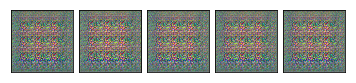

--- EPOCH 2/100 ---
100%|██████████| 17/17 [00:04<00:00,  4.04it/s]
Discriminator loss: 0.3881851971587714
Generator loss:     2.7833711399751553


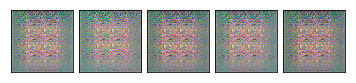

--- EPOCH 3/100 ---
100%|██████████| 17/17 [00:04<00:00,  4.25it/s]
Discriminator loss: 0.5498058033340117
Generator loss:     3.0290769128238453


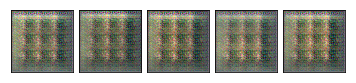

--- EPOCH 4/100 ---
100%|██████████| 17/17 [00:04<00:00,  4.31it/s]
Discriminator loss: 0.7556596722672967
Generator loss:     2.767623690997853


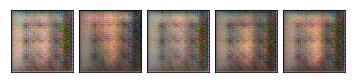

--- EPOCH 5/100 ---
100%|██████████| 17/17 [00:04<00:00,  4.30it/s]
Discriminator loss: 0.8587193489074707
Generator loss:     2.575843993355246


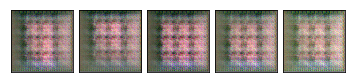

--- EPOCH 6/100 ---
100%|██████████| 17/17 [00:04<00:00,  4.42it/s]
Discriminator loss: 0.5205586412373711
Generator loss:     2.4642401512931373


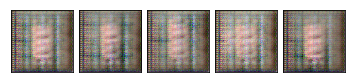

--- EPOCH 7/100 ---
100%|██████████| 17/17 [00:04<00:00,  4.49it/s]
Discriminator loss: 0.8309725803487441
Generator loss:     2.552389790030087


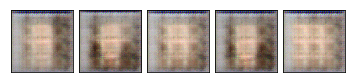

--- EPOCH 8/100 ---
100%|██████████| 17/17 [00:04<00:00,  4.49it/s]
Discriminator loss: 0.6677656725925558
Generator loss:     2.518144495346967


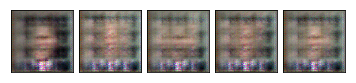

--- EPOCH 9/100 ---
100%|██████████| 17/17 [00:04<00:00,  4.53it/s]
Discriminator loss: 1.044725372510798
Generator loss:     2.331610307973974


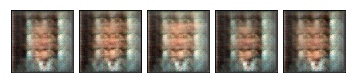

--- EPOCH 10/100 ---
100%|██████████| 17/17 [00:04<00:00,  4.57it/s]
Discriminator loss: 0.8217393247520223
Generator loss:     2.2808494287378647


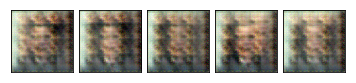

--- EPOCH 11/100 ---
100%|██████████| 17/17 [00:04<00:00,  4.60it/s]
Discriminator loss: 0.8136250306578243
Generator loss:     2.3408684099421784


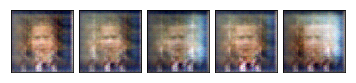

--- EPOCH 12/100 ---
100%|██████████| 17/17 [00:04<00:00,  4.38it/s]
Discriminator loss: 1.0571978583055384
Generator loss:     1.9580153577467974


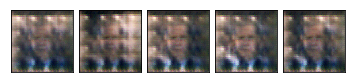

--- EPOCH 13/100 ---
100%|██████████| 17/17 [00:04<00:00,  4.57it/s]
Discriminator loss: 0.9246333767386044
Generator loss:     2.034786848460927


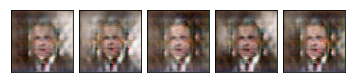

--- EPOCH 14/100 ---
100%|██████████| 17/17 [00:04<00:00,  4.62it/s]
Discriminator loss: 0.8342076364685508
Generator loss:     2.306601790820851


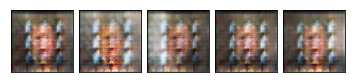

--- EPOCH 15/100 ---
100%|██████████| 17/17 [00:04<00:00,  4.61it/s]
Discriminator loss: 0.9040282263475306
Generator loss:     2.3262660713756786


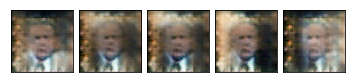

--- EPOCH 16/100 ---
100%|██████████| 17/17 [00:04<00:00,  4.55it/s]
Discriminator loss: 0.7950605381937588
Generator loss:     2.3295242576038135


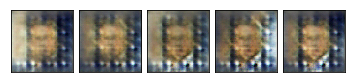

--- EPOCH 17/100 ---
100%|██████████| 17/17 [00:04<00:00,  4.55it/s]
Discriminator loss: 0.8551986007129445
Generator loss:     2.2298957530189965


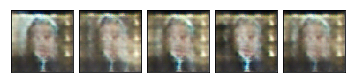

--- EPOCH 18/100 ---
100%|██████████| 17/17 [00:04<00:00,  4.37it/s]
Discriminator loss: 0.9220902709399953
Generator loss:     2.0466194012585808


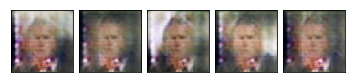

--- EPOCH 19/100 ---
100%|██████████| 17/17 [00:04<00:00,  3.93it/s]
Discriminator loss: 0.8268923198475557
Generator loss:     2.264548115870532


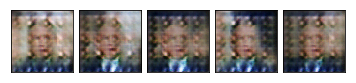

--- EPOCH 20/100 ---
100%|██████████| 17/17 [00:04<00:00,  4.60it/s]
Discriminator loss: 1.0701799532946419
Generator loss:     1.8389273671542896


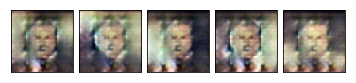

--- EPOCH 21/100 ---
100%|██████████| 17/17 [00:04<00:00,  4.38it/s]
Discriminator loss: 0.8639131959746865
Generator loss:     2.1665598644929775


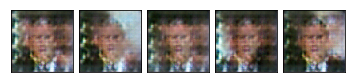

--- EPOCH 22/100 ---
100%|██████████| 17/17 [00:04<00:00,  4.51it/s]
Discriminator loss: 0.8943367530317867
Generator loss:     1.9497186506495756


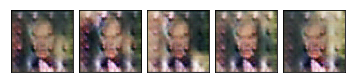

--- EPOCH 23/100 ---
100%|██████████| 17/17 [00:04<00:00,  4.43it/s]
Discriminator loss: 0.6985085501390345
Generator loss:     2.307131928556106


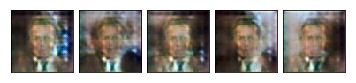

--- EPOCH 24/100 ---
100%|██████████| 17/17 [00:04<00:00,  4.55it/s]
Discriminator loss: 0.9112223982810974
Generator loss:     1.983705394408282


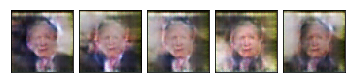

--- EPOCH 25/100 ---
100%|██████████| 17/17 [00:04<00:00,  4.57it/s]
Discriminator loss: 0.6348033494809094
Generator loss:     2.402900415308335


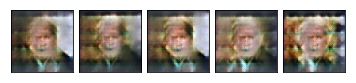

--- EPOCH 26/100 ---
100%|██████████| 17/17 [00:04<00:00,  4.31it/s]
Discriminator loss: 0.9804061125306522
Generator loss:     2.0706241481444416


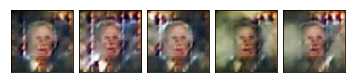

--- EPOCH 27/100 ---
100%|██████████| 17/17 [00:04<00:00,  4.35it/s]
Discriminator loss: 0.9624758222523857
Generator loss:     1.9729804887491114


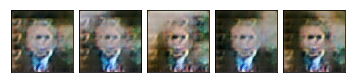

--- EPOCH 28/100 ---
100%|██████████| 17/17 [00:04<00:00,  4.49it/s]
Discriminator loss: 0.7689449401462779
Generator loss:     1.9973413453382605


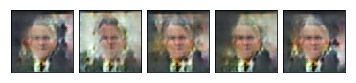

--- EPOCH 29/100 ---
100%|██████████| 17/17 [00:04<00:00,  4.38it/s]
Discriminator loss: 0.841330398531521
Generator loss:     2.025265763787662


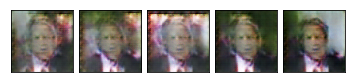

--- EPOCH 30/100 ---
100%|██████████| 17/17 [00:04<00:00,  4.12it/s]
Discriminator loss: 0.8648172616958618
Generator loss:     2.0867215394973755


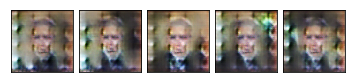

--- EPOCH 31/100 ---
100%|██████████| 17/17 [00:04<00:00,  4.11it/s]
Discriminator loss: 0.731018883340499
Generator loss:     2.381477440104765


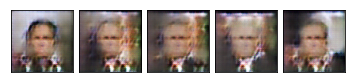

--- EPOCH 32/100 ---
100%|██████████| 17/17 [00:05<00:00,  3.29it/s]
Discriminator loss: 0.6260060878360972
Generator loss:     2.335019854938283


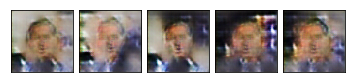

--- EPOCH 33/100 ---
100%|██████████| 17/17 [00:04<00:00,  4.41it/s]
Discriminator loss: 0.9580507664119496
Generator loss:     2.0139843961771797


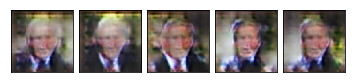

--- EPOCH 34/100 ---
100%|██████████| 17/17 [00:04<00:00,  4.37it/s]
Discriminator loss: 0.7735404056661269
Generator loss:     1.9962868339875166


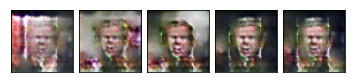

--- EPOCH 35/100 ---
100%|██████████| 17/17 [00:04<00:00,  4.31it/s]
Discriminator loss: 0.7487367882448084
Generator loss:     2.3648250383489273


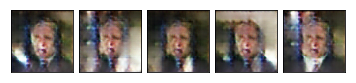

--- EPOCH 36/100 ---
100%|██████████| 17/17 [00:04<00:00,  4.31it/s]
Discriminator loss: 0.9301565850482267
Generator loss:     2.1798453050501205


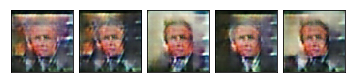

--- EPOCH 37/100 ---
100%|██████████| 17/17 [00:04<00:00,  4.42it/s]
Discriminator loss: 0.9424912193242241
Generator loss:     1.9491202901391422


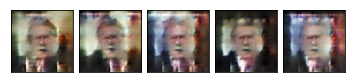

--- EPOCH 38/100 ---
100%|██████████| 17/17 [00:04<00:00,  4.19it/s]
Discriminator loss: 0.7757295054547927
Generator loss:     2.2045266488019157


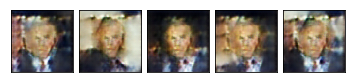

--- EPOCH 39/100 ---
100%|██████████| 17/17 [00:04<00:00,  4.30it/s]
Discriminator loss: 0.6910851282231948
Generator loss:     2.4036224870120777


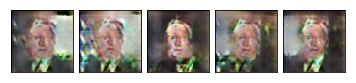

--- EPOCH 40/100 ---
100%|██████████| 17/17 [00:04<00:00,  4.41it/s]
Discriminator loss: 0.6915640550501206
Generator loss:     2.3457305431365967


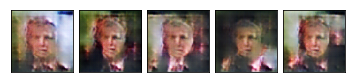

--- EPOCH 41/100 ---
100%|██████████| 17/17 [00:04<00:00,  4.44it/s]
Discriminator loss: 0.9957500065074247
Generator loss:     2.1287186987259807


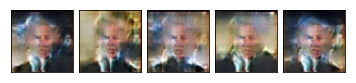

--- EPOCH 42/100 ---
100%|██████████| 17/17 [00:04<00:00,  4.38it/s]
Discriminator loss: 0.8838660822195166
Generator loss:     2.1436621722053077


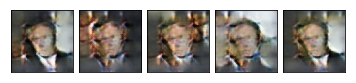

--- EPOCH 43/100 ---
100%|██████████| 17/17 [00:04<00:00,  4.42it/s]
Discriminator loss: 0.8125118350281435
Generator loss:     2.3599236923105575


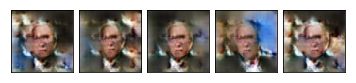

--- EPOCH 44/100 ---
100%|██████████| 17/17 [00:04<00:00,  4.25it/s]
Discriminator loss: 0.878220302217147
Generator loss:     2.1335721296422623


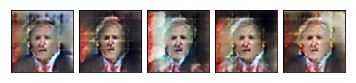

--- EPOCH 45/100 ---
100%|██████████| 17/17 [00:04<00:00,  4.20it/s]
Discriminator loss: 0.8517931839999031
Generator loss:     2.1476692452150234


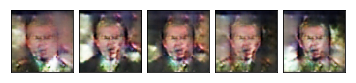

--- EPOCH 46/100 ---
100%|██████████| 17/17 [00:04<00:00,  4.27it/s]
Discriminator loss: 0.820250821464202
Generator loss:     2.106729738852557


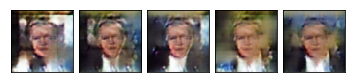

--- EPOCH 47/100 ---
100%|██████████| 17/17 [00:04<00:00,  4.23it/s]
Discriminator loss: 0.792623453280505
Generator loss:     2.1452608704566956


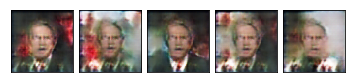

--- EPOCH 48/100 ---
100%|██████████| 17/17 [00:04<00:00,  3.91it/s]
Discriminator loss: 0.8538848214289722
Generator loss:     2.224435140104855


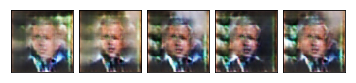

--- EPOCH 49/100 ---
100%|██████████| 17/17 [00:04<00:00,  4.32it/s]
Discriminator loss: 0.6604317917543299
Generator loss:     2.329096422475927


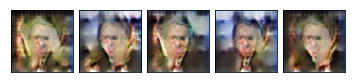

--- EPOCH 50/100 ---
100%|██████████| 17/17 [00:04<00:00,  4.28it/s]
Discriminator loss: 0.8712561901877908
Generator loss:     2.300693582086002


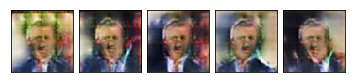

--- EPOCH 51/100 ---
100%|██████████| 17/17 [00:04<00:00,  4.40it/s]
Discriminator loss: 0.8241672130192027
Generator loss:     2.0233398535672356


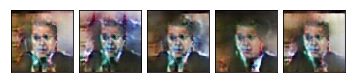

--- EPOCH 52/100 ---
100%|██████████| 17/17 [00:04<00:00,  4.38it/s]
Discriminator loss: 0.6797150128027972
Generator loss:     2.2985969080644497


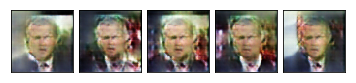

--- EPOCH 53/100 ---
100%|██████████| 17/17 [00:04<00:00,  4.40it/s]
Discriminator loss: 0.8910316334051245
Generator loss:     2.061702910591574


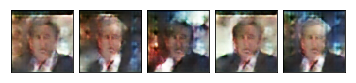

--- EPOCH 54/100 ---
100%|██████████| 17/17 [00:04<00:00,  4.41it/s]
Discriminator loss: 0.9233283190166249
Generator loss:     1.955663800239563


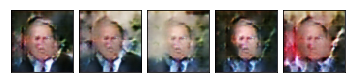

--- EPOCH 55/100 ---
100%|██████████| 17/17 [00:04<00:00,  4.45it/s]
Discriminator loss: 0.7844518510734334
Generator loss:     2.1462951758328606


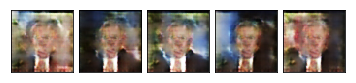

--- EPOCH 56/100 ---
100%|██████████| 17/17 [00:04<00:00,  4.40it/s]
Discriminator loss: 0.8555987442240995
Generator loss:     2.18895258623011


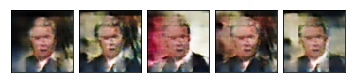

--- EPOCH 57/100 ---
100%|██████████| 17/17 [00:04<00:00,  4.33it/s]
Discriminator loss: 0.7746359320247874
Generator loss:     2.3081215620040894


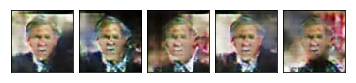

--- EPOCH 58/100 ---
100%|██████████| 17/17 [00:04<00:00,  4.16it/s]
Discriminator loss: 0.7925016143742729
Generator loss:     2.166515420464908


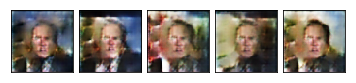

--- EPOCH 59/100 ---
100%|██████████| 17/17 [00:04<00:00,  4.43it/s]
Discriminator loss: 0.7502581757657668
Generator loss:     2.098221133737003


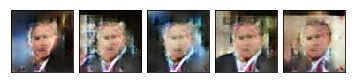

--- EPOCH 60/100 ---
100%|██████████| 17/17 [00:04<00:00,  4.45it/s]
Discriminator loss: 1.074560656267054
Generator loss:     1.9165651763186735


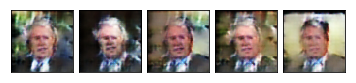

--- EPOCH 61/100 ---
100%|██████████| 17/17 [00:04<00:00,  4.53it/s]
Discriminator loss: 0.8602343306821936
Generator loss:     1.842422737794764


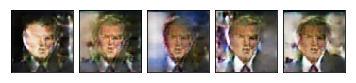

--- EPOCH 62/100 ---
100%|██████████| 17/17 [00:04<00:00,  4.52it/s]
Discriminator loss: 0.8924368129057043
Generator loss:     1.986956975039314


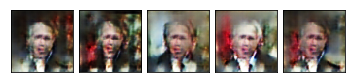

--- EPOCH 63/100 ---
100%|██████████| 17/17 [00:04<00:00,  4.39it/s]
Discriminator loss: 0.8498116521274343
Generator loss:     2.210823563968434


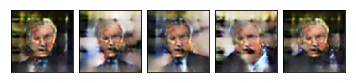

--- EPOCH 64/100 ---
100%|██████████| 17/17 [00:04<00:00,  4.49it/s]
Discriminator loss: 0.7235390473814571
Generator loss:     2.1103115362279556


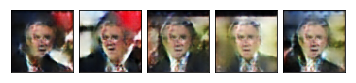

--- EPOCH 65/100 ---
100%|██████████| 17/17 [00:04<00:00,  4.47it/s]
Discriminator loss: 0.9386399773990407
Generator loss:     1.9257289381588207


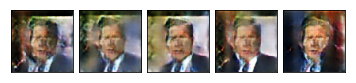

--- EPOCH 66/100 ---
100%|██████████| 17/17 [00:04<00:00,  4.38it/s]
Discriminator loss: 0.7516737825730267
Generator loss:     2.067568161908318


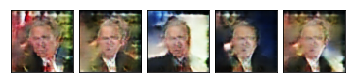

--- EPOCH 67/100 ---
100%|██████████| 17/17 [00:04<00:00,  4.60it/s]
Discriminator loss: 0.7603916946579429
Generator loss:     2.1750598970581505


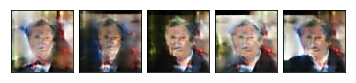

--- EPOCH 68/100 ---
100%|██████████| 17/17 [00:04<00:00,  4.43it/s]
Discriminator loss: 0.9228892536724315
Generator loss:     2.0556079745292664


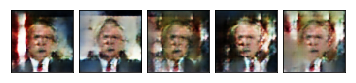

--- EPOCH 69/100 ---
100%|██████████| 17/17 [00:04<00:00,  4.31it/s]
Discriminator loss: 0.9427143475588631
Generator loss:     2.133737318656024


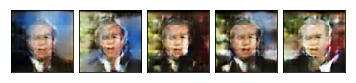

--- EPOCH 70/100 ---
100%|██████████| 17/17 [00:04<00:00,  4.40it/s]
Discriminator loss: 0.9147859566351947
Generator loss:     2.0109584892497345


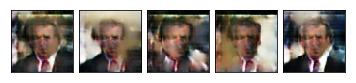

--- EPOCH 71/100 ---
100%|██████████| 17/17 [00:04<00:00,  4.37it/s]
Discriminator loss: 0.8133667917812571
Generator loss:     2.1414417940027572


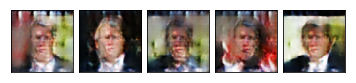

--- EPOCH 72/100 ---
100%|██████████| 17/17 [00:04<00:00,  4.34it/s]
Discriminator loss: 0.7778558608363656
Generator loss:     2.163594540427713


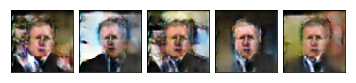

--- EPOCH 73/100 ---
100%|██████████| 17/17 [00:04<00:00,  4.30it/s]
Discriminator loss: 0.8394272011869094
Generator loss:     1.9701066367766435


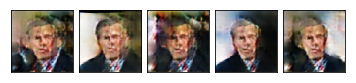

--- EPOCH 74/100 ---
100%|██████████| 17/17 [00:04<00:00,  3.98it/s]
Discriminator loss: 0.901513885049259
Generator loss:     2.1082954862538505


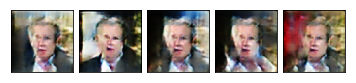

--- EPOCH 75/100 ---
100%|██████████| 17/17 [00:04<00:00,  4.44it/s]
Discriminator loss: 0.8128976295976078
Generator loss:     1.8341052532196045


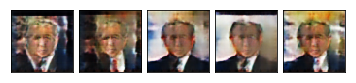

--- EPOCH 76/100 ---
100%|██████████| 17/17 [00:04<00:00,  4.28it/s]
Discriminator loss: 0.8415378314607284
Generator loss:     2.052747803575852


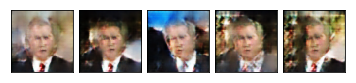

--- EPOCH 77/100 ---
100%|██████████| 17/17 [00:04<00:00,  4.37it/s]
Discriminator loss: 0.8042657971382141
Generator loss:     2.142130402957692


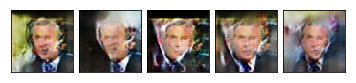

--- EPOCH 78/100 ---
100%|██████████| 17/17 [00:04<00:00,  4.29it/s]
Discriminator loss: 0.7084969387334936
Generator loss:     2.301586066975313


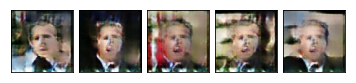

--- EPOCH 79/100 ---
100%|██████████| 17/17 [00:04<00:00,  4.43it/s]
Discriminator loss: 0.776415244621389
Generator loss:     2.0908860949908985


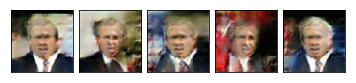

--- EPOCH 80/100 ---
100%|██████████| 17/17 [00:04<00:00,  4.47it/s]
Discriminator loss: 0.7028483906212974
Generator loss:     2.0763599031111775


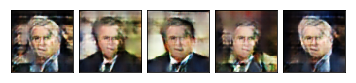

--- EPOCH 81/100 ---
100%|██████████| 17/17 [00:04<00:00,  4.44it/s]
Discriminator loss: 0.7579240325619193
Generator loss:     2.2571312750087067


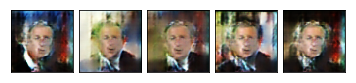

--- EPOCH 82/100 ---
100%|██████████| 17/17 [00:04<00:00,  4.52it/s]
Discriminator loss: 0.7952535222558414
Generator loss:     2.328613933394937


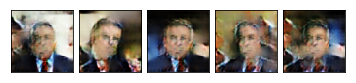

--- EPOCH 83/100 ---
100%|██████████| 17/17 [00:04<00:00,  4.41it/s]
Discriminator loss: 0.6246475507231319
Generator loss:     2.3718799492892098


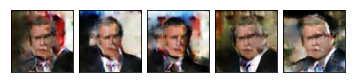

--- EPOCH 84/100 ---
100%|██████████| 17/17 [00:04<00:00,  4.51it/s]
Discriminator loss: 0.7150677810696995
Generator loss:     2.290893218096565


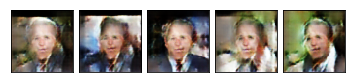

--- EPOCH 85/100 ---
100%|██████████| 17/17 [00:04<00:00,  4.44it/s]
Discriminator loss: 0.6998932414195117
Generator loss:     2.2165399228825287


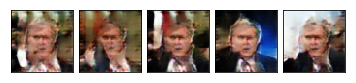

--- EPOCH 86/100 ---
100%|██████████| 17/17 [00:04<00:00,  4.42it/s]
Discriminator loss: 0.6423442977316239
Generator loss:     2.3935450385598576


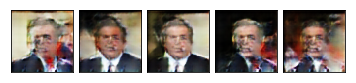

--- EPOCH 87/100 ---
100%|██████████| 17/17 [00:04<00:00,  4.33it/s]
Discriminator loss: 0.8356549038606531
Generator loss:     2.196818667299607


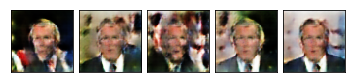

--- EPOCH 88/100 ---
100%|██████████| 17/17 [00:04<00:00,  4.44it/s]
Discriminator loss: 0.7588953200508567
Generator loss:     2.2332150164772484


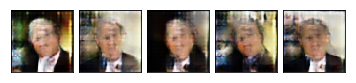

--- EPOCH 89/100 ---
100%|██████████| 17/17 [00:04<00:00,  4.44it/s]
Discriminator loss: 0.6694706766044393
Generator loss:     2.4442130116855396


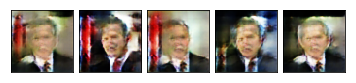

--- EPOCH 90/100 ---
100%|██████████| 17/17 [00:04<00:00,  4.44it/s]
Discriminator loss: 0.7161655408494613
Generator loss:     2.424021005630493


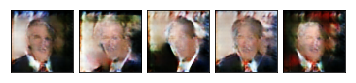

--- EPOCH 91/100 ---
100%|██████████| 17/17 [00:04<00:00,  4.46it/s]
Discriminator loss: 0.7557874584899229
Generator loss:     2.2030291767681347


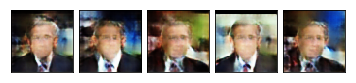

--- EPOCH 92/100 ---
100%|██████████| 17/17 [00:04<00:00,  4.39it/s]
Discriminator loss: 0.6647577127989601
Generator loss:     2.3276963865055755


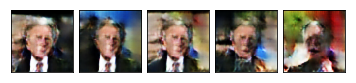

--- EPOCH 93/100 ---
100%|██████████| 17/17 [00:04<00:00,  4.31it/s]
Discriminator loss: 0.8198400525485768
Generator loss:     2.257774324978099


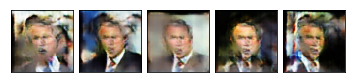

--- EPOCH 94/100 ---
100%|██████████| 17/17 [00:04<00:00,  4.37it/s]
Discriminator loss: 0.72068231771974
Generator loss:     2.3068615478627823


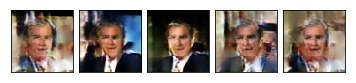

--- EPOCH 95/100 ---
100%|██████████| 17/17 [00:04<00:00,  4.55it/s]
Discriminator loss: 0.675326513893464
Generator loss:     2.347480724839603


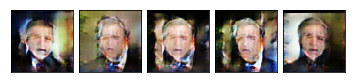

--- EPOCH 96/100 ---
100%|██████████| 17/17 [00:04<00:00,  4.05it/s]
Discriminator loss: 0.5523750396335826
Generator loss:     2.640512164901285


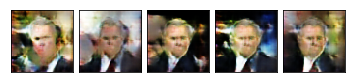

--- EPOCH 97/100 ---
100%|██████████| 17/17 [00:04<00:00,  4.14it/s]
Discriminator loss: 0.8522126622059766
Generator loss:     2.418338021811317


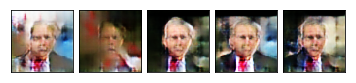

--- EPOCH 98/100 ---
100%|██████████| 17/17 [00:04<00:00,  4.35it/s]
Discriminator loss: 0.6561198585173663
Generator loss:     2.366072381243986


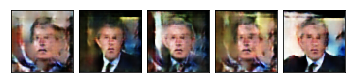

--- EPOCH 99/100 ---
100%|██████████| 17/17 [00:04<00:00,  4.20it/s]
Discriminator loss: 0.5231608222512638
Generator loss:     2.599700121318593


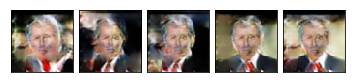

--- EPOCH 100/100 ---
 47%|████▋     | 8/17 [00:02<00:02,  3.73it/s]

In [ ]:
import IPython.display
import tqdm
from hw3.gan import train_batch

num_epochs = 100

if os.path.isfile(f'{checkpoint_file_final}.pt'):
    print(f'*** Loading final checkpoint file {checkpoint_file_final} instead of training')
    num_epochs = 0
    gen = torch.load(f'{checkpoint_file_final}.pt', map_location=device)
    checkpoint_file = checkpoint_file_final

for epoch_idx in range(num_epochs):
    # We'll accumulate batch losses and show an average once per epoch.
    dsc_losses = []
    gen_losses = []
    print(f'--- EPOCH {epoch_idx+1}/{num_epochs} ---')
    
    with tqdm.tqdm(total=len(dl_train.batch_sampler), file=sys.stdout) as pbar:
        for batch_idx, (x_data, _) in enumerate(dl_train):
            x_data = x_data.to(device)
            dsc_loss, gen_loss = train_batch(
                dsc, gen,
                dsc_loss_fn, gen_loss_fn,
                dsc_optimizer, gen_optimizer,
                x_data)
            dsc_losses.append(dsc_loss)
            gen_losses.append(gen_loss)
            pbar.update()

    dsc_avg_loss, gen_avg_loss = np.mean(dsc_losses), np.mean(gen_losses)
    print(f'Discriminator loss: {dsc_avg_loss}')
    print(f'Generator loss:     {gen_avg_loss}')
        
    samples = gen.sample(5, with_grad=False)
    fig, _ = plot.tensors_as_images(samples.cpu(), figsize=(6,2))
    IPython.display.display(fig)
    plt.close(fig)


In [ ]:
# Plot images from best or last model
if os.path.isfile(f'{checkpoint_file}.pt'):
    gen = torch.load(f'{checkpoint_file}.pt', map_location=device)
print('*** Images Generated from best model:')
samples = gen.sample(n=15, with_grad=False).cpu()
fig, _ = plot.tensors_as_images(samples, nrows=3, figsize=(6,6))

## Questions
<a id=part3_8></a>

**TODO** Answer the following questions. Write your answers in the appropriate variables in the module `hw3/answers.py`.

In [ ]:
from cs236605.answers import display_answer
import hw3.answers

### Question 1

Explain in detail why during training we sometimes need to maintain gradients when sampling from the GAN,
and other times we don't. When are they maintained and why? When are they discarded and why?

In [ ]:
display_answer(hw3.answers.part3_q1)

### Question 2

1. When training a GAN to generate images, should we decide to stop training solely based on the fact that  the Generator loss is below some threshold?
Why or why not?

2. What does it mean if the discriminator loss remains at a constant value while the generator loss decreases?

In [ ]:
display_answer(hw3.answers.part3_q2)

### Question 2

Compare the results you got when generating images with the VAE to the GAN results.
What's the main difference and what's causing it?

In [ ]:
display_answer(hw3.answers.part3_q3)